In [1]:
### ----- Imports ----- ###

import matplotlib.pyplot as plt
import numpy as np
import os.path
import os
import shutil
import glob
import h5py
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

dataset = 'v1b'

In [3]:
### ----- Parameters ----- ###

# Where to save the products
models_figs_path = '/home/sdybing/mlaapde/figures/'

# MLAAPDE/data generation params
#nsamp = False # Samples of waveforms to load from MLAAPDE
#n_train_samp = 1000000
#n_valid_samp = 200000
#nsamp = n_train_samp + n_valid_samp
sr = 20 # Sampling rate
trim_sec = 60 # Trimming amount around phase pick to get from MLAAPDE
trim_pre_sec = trim_sec
trim_post_sec = trim_pre_sec
window_len = trim_pre_sec + trim_post_sec
#train_split = 0.8 # Percentage of data used in training
#valid_split = 0.2 # Percentage of data used for validation
n_channels = 3 # Instrument channels
cut_lens = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
cut_lens_finish = [70, 80, 90, 100, 110, 120]
cut_lens_test = [7, 120]
desired_shift = 3
max_shift = desired_shift * 2 # Since the shifting method actually makes it half what this value is set to
min_snr_db = False
max_snr_db = False
log_progress_fraction = 100
valid_phases = ['P', 'Pn', 'Pg']
cast_dtype = np.float32

# Training/model params
epochs_number = 200
batch_size = int(256) # Reducing to help memory
monte_carlo_sampling = 50
drop_rate = 0.5
filters = [32, 64, 96, 128, 256] 

# Used if loading a trained model
training_dataset = 'v1b'
shift_status = 'shifted'
model_folder_path = '/home/sdybing/mlaapde/training/'

# To make end error plots
mean_errors = []
std_errors = []

In [4]:
hdf5_save_dir = '/hdd/mlaapde/decimated'

In [5]:
### ----- Load the full dataset from HDF5 files ----- ###

testing_data = h5py.File(hdf5_save_dir + '/testing_data.hdf5', 'r')
test_waves = testing_data['waves'][:]
test_mags = testing_data['magnitude'][:]
test_phase_id = testing_data['phase_id'][:]

testing_data.close()

In [6]:
print(test_waves.shape)
print(test_mags.shape)

(324365, 3, 2400)
(324365,)


In [7]:
test_waves_t = test_waves.transpose(0,2,1)

print(test_waves_t.shape)
print(test_mags.shape)

(324365, 2400, 3)
(324365,)


In [8]:
del test_waves

In [9]:
nsamp = 2920609
n_test_samp = len(test_mags)
data = 'testing'

Cut len: 7
Model: /home/sdybing/mlaapde/training/v1b_2920609samps_1s_window/v1b_2920609samps_1s_001.h5
Loading weights...
Predicting...


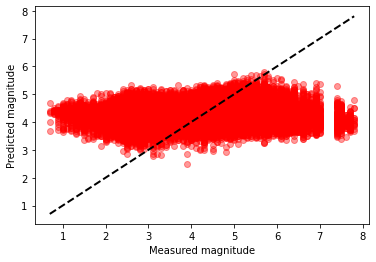

Mean error: 0.236
Error standard deviation: 0.97
Rupture duration: 0.5 seconds
M0: 7.8125e+21 dyne-cm
Mw: 3.87


<ipython-input-11-8e1373815128>:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8], fontsize = 14, color = 'black')


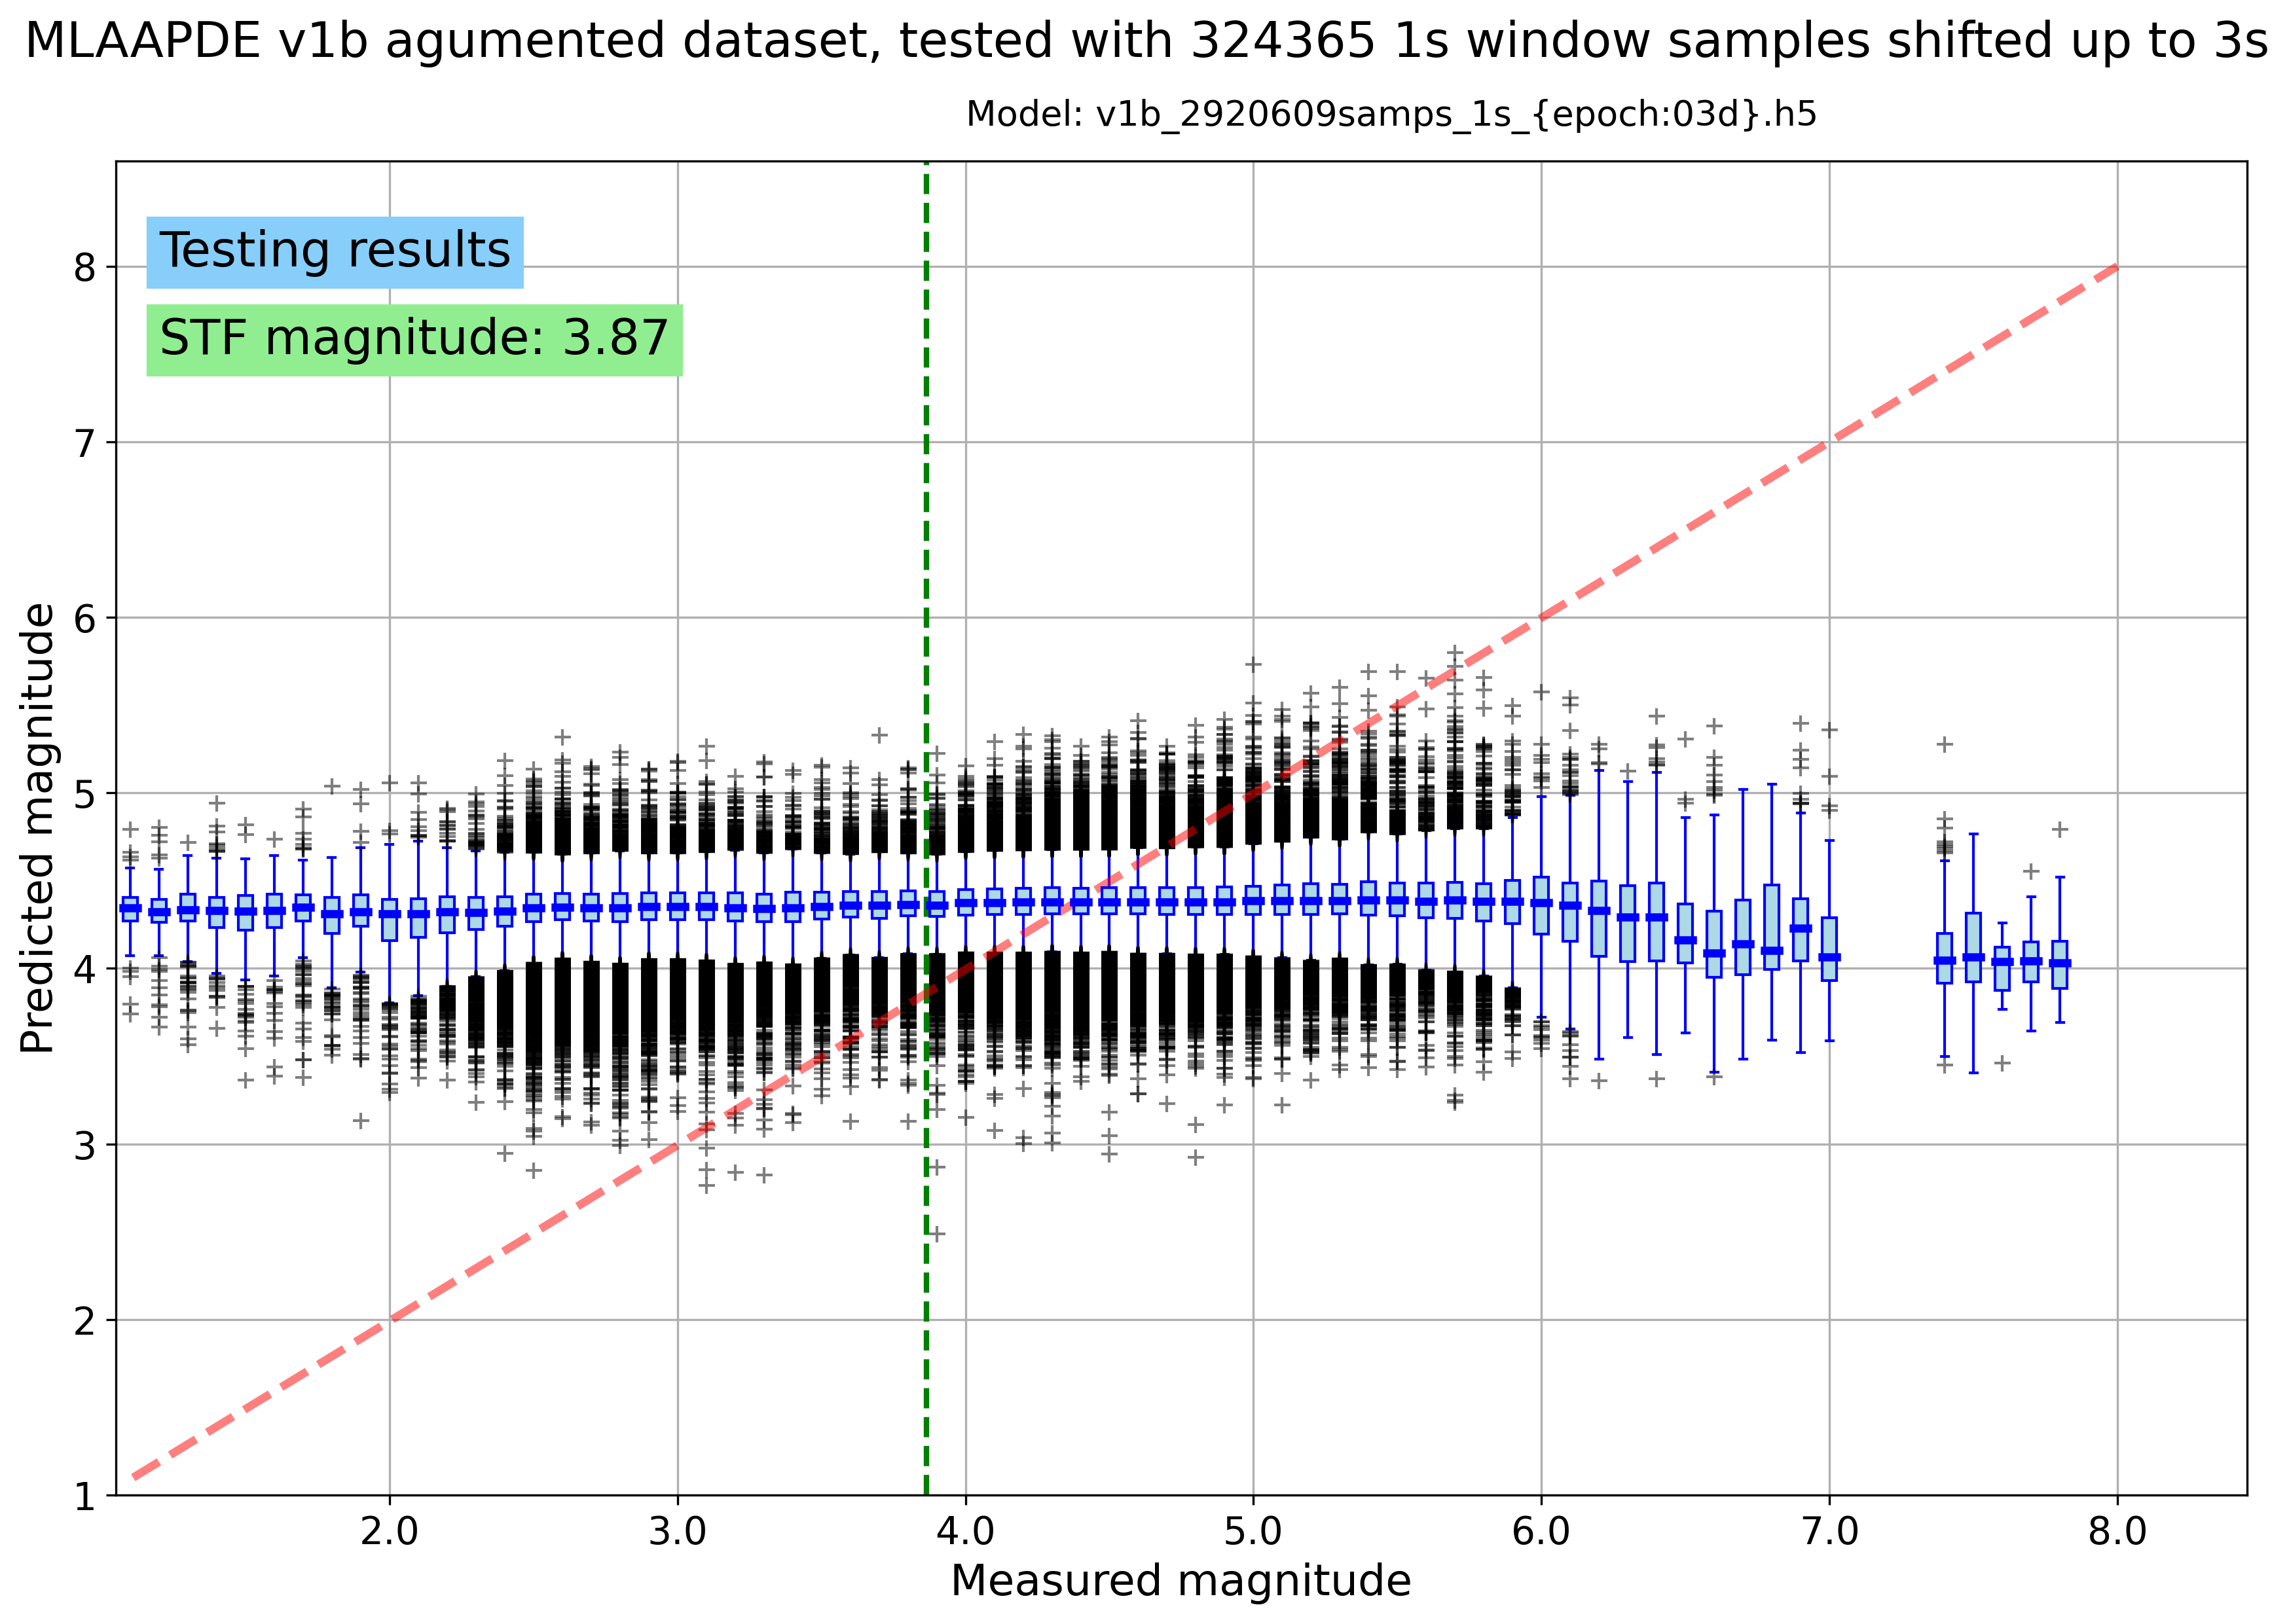

Cut len: 120
Model: /home/sdybing/mlaapde/training/v1b_2920609samps_114s_window/v1b_2920609samps_114s_029.h5
Loading weights...
Predicting...


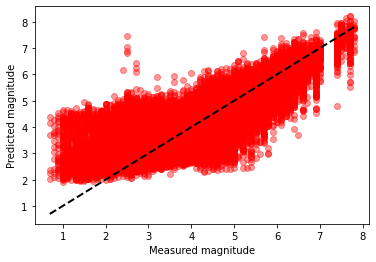

Mean error: 0.116
Error standard deviation: 0.51
Rupture duration: 57.0 seconds
M0: 1.15745625e+28 dyne-cm
Mw: 7.98


<ipython-input-11-8e1373815128>:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8], fontsize = 14, color = 'black')


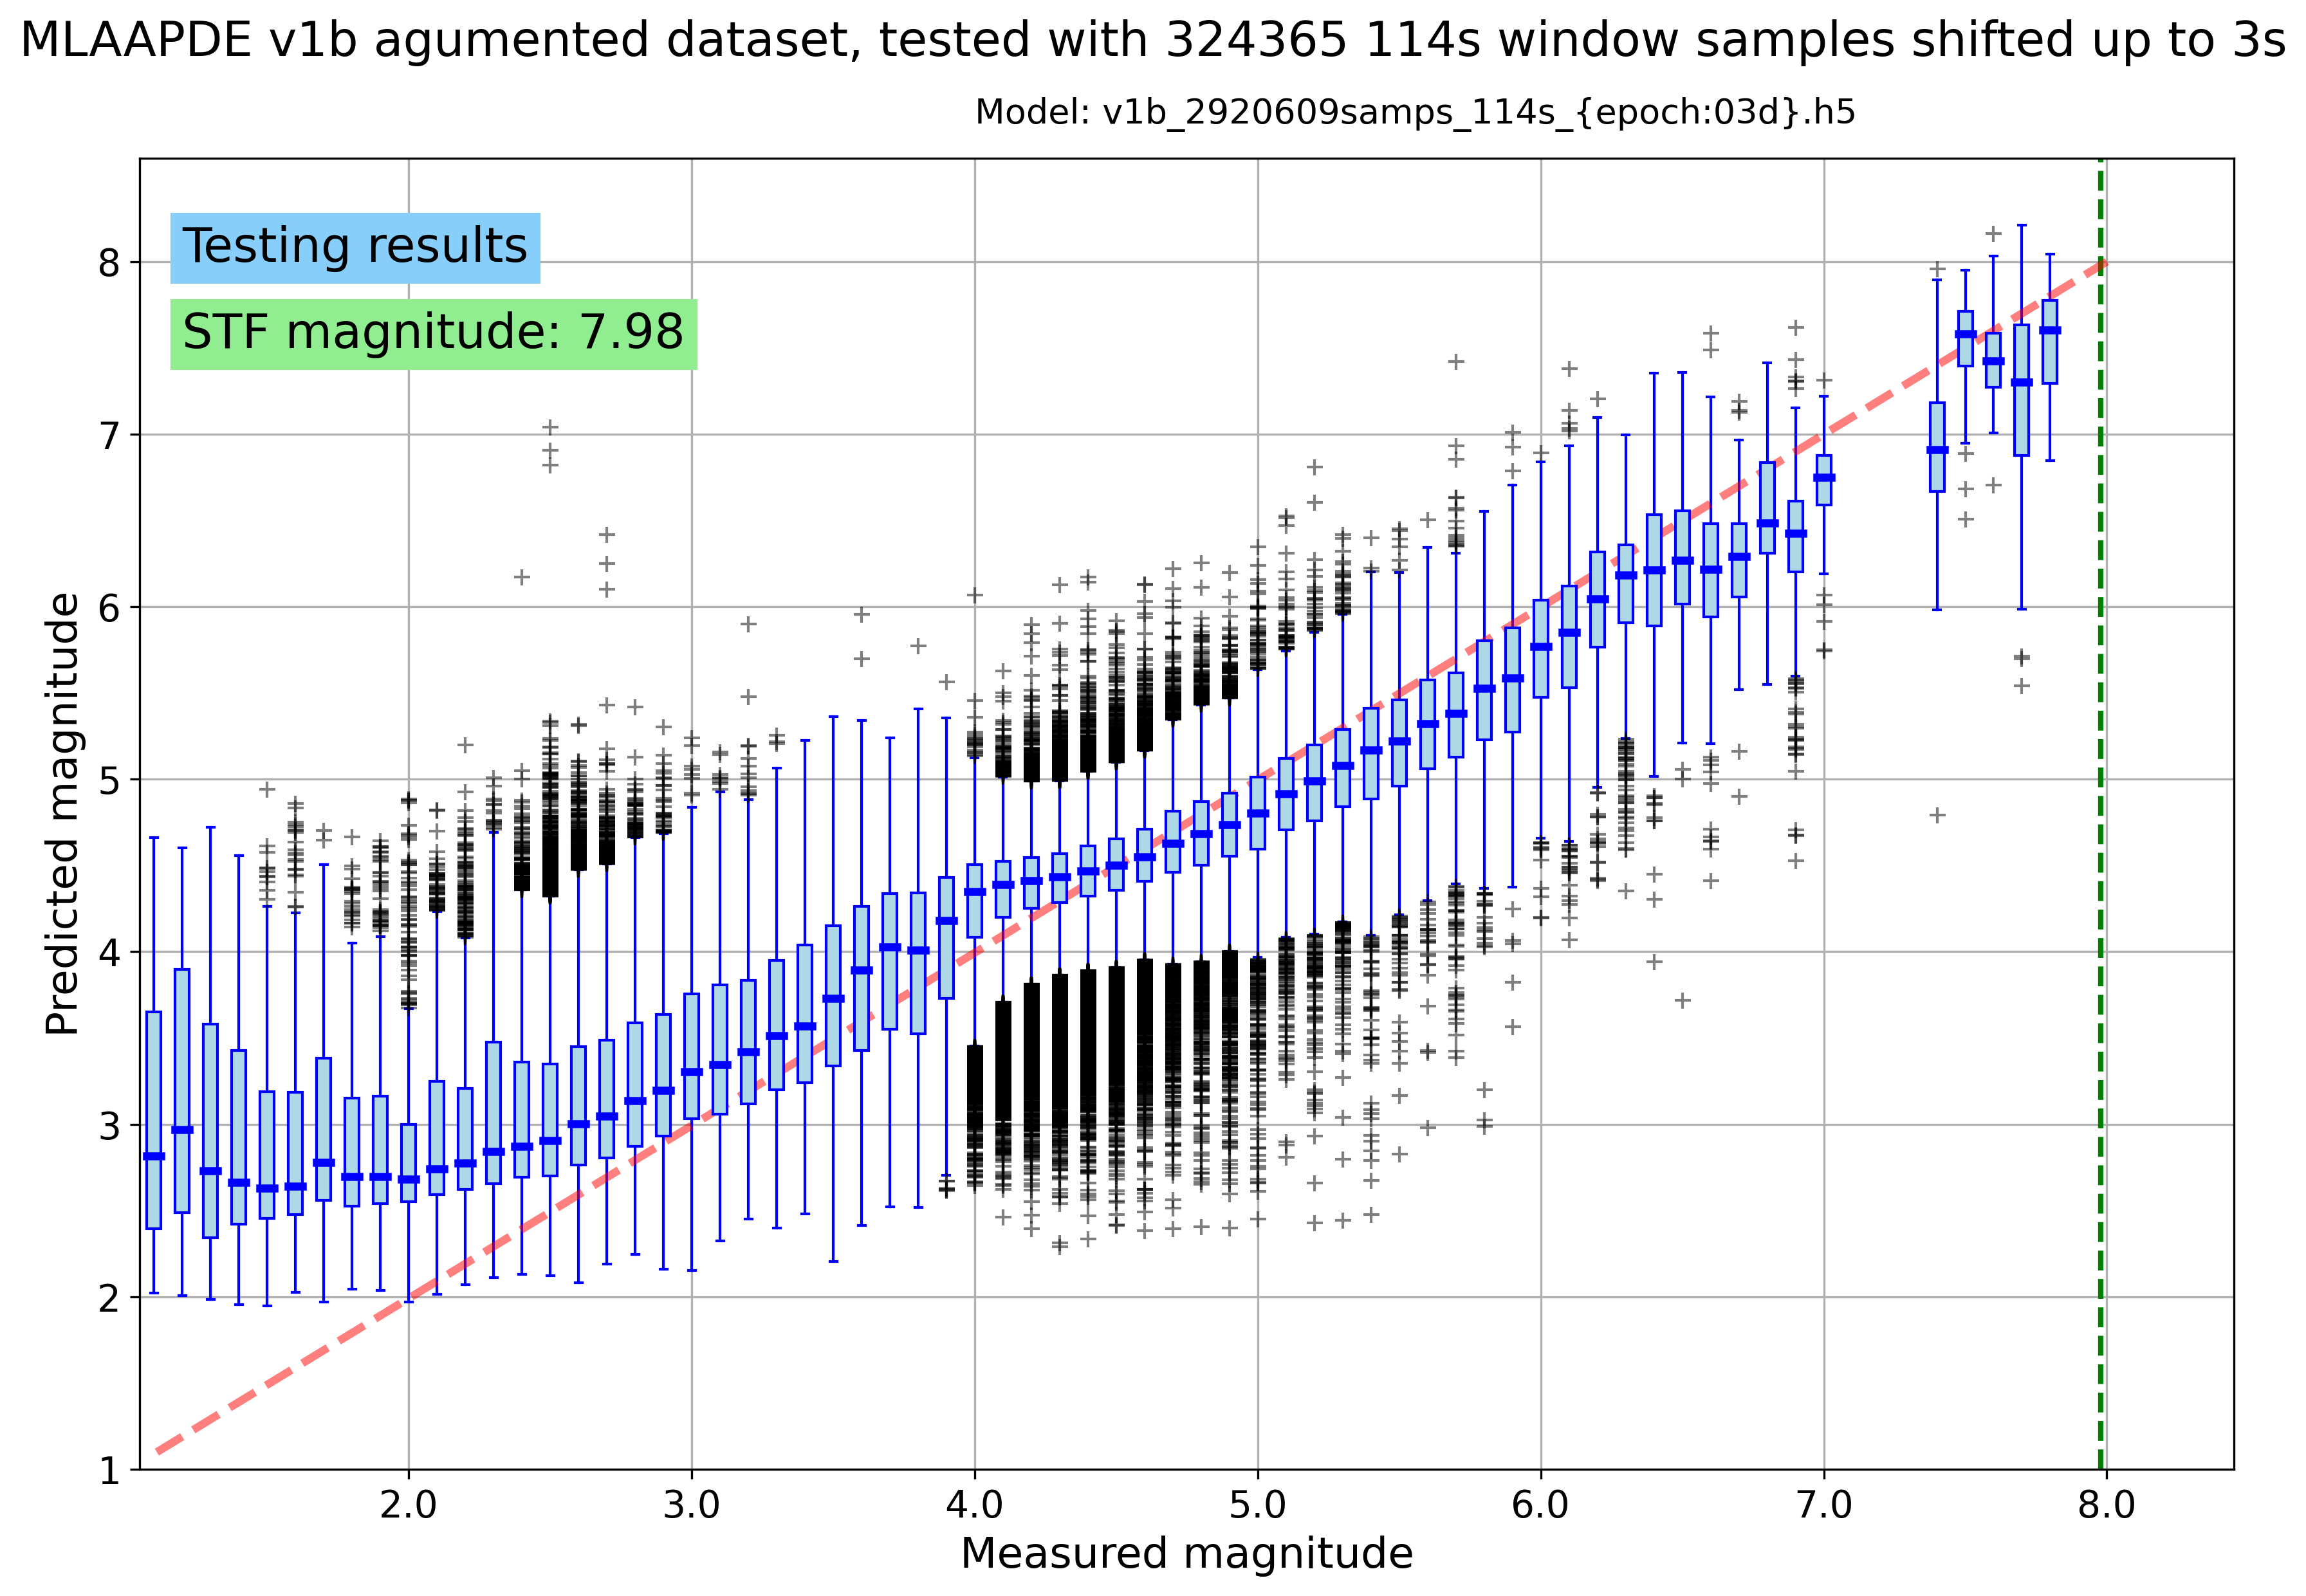

In [11]:
########## STUFF THAT NEEDS LOOPING ##########

debug = False

for cut_len in cut_lens_test:
    print('Cut len: ' + str(cut_len))
    
    ### ----- Where are the trained models/figures getting saved? ----- ###

    save_dir = models_figs_path + data + '/' + str(dataset) + '_' + str(nsamp) + 'samps_' + str(cut_len-6) + 's_window'
    if os.path.isdir(save_dir):
        pass
    else: # deletes directory to start over: shutil.rmtree(save_dir)  
        os.makedirs(save_dir)

    ### ----- Cut and shift testing data to match the training data ----- ###

    ## Cut ##
    if debug:
        rand = np.random.choice(np.arange(0,len(test_mags),1))
        print('Rand: ' + str(rand))
        test_times = np.arange(0, window_len, 1/sr)
        plt.figure(facecolor = 'white')
        plt.suptitle('Original test data')
        plt.subplot(311)
        plt.plot(test_times, test_waves_t[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(test_times, test_waves_t[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(test_times, test_waves_t[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();
    
    middle = int(test_waves_t.shape[1] / 2)
    if debug: print('Middle: ' + str(middle))
    test_size = int(n_test_samp)
    if debug: print('test size: ' + str(test_size))
    cut_test_waves_t = np.zeros((test_size, int(cut_len*sr), 3)) 
    if debug: print('Cut waves t shape: ' + str(cut_test_waves_t.shape))

    for i in range(len(test_waves_t)):
        cut_test_waves_t[i,] = test_waves_t[i, int(middle - (cut_len/2)*sr) : int(middle + (cut_len/2)*sr), 0:3]
    if debug: print('Cut waves t shape: ' + str(cut_test_waves_t.shape))
    if debug:
        test_cut_times = np.arange(0, cut_len, 1/sr)
        print('Rand: ' + str(rand))
        plt.figure(facecolor = 'white')
        plt.suptitle('Cut test data')
        plt.subplot(311)
        plt.plot(test_cut_times, cut_test_waves_t[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(test_cut_times, cut_test_waves_t[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(test_cut_times, cut_test_waves_t[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();

    ## Shift ##
    shift_len = cut_len - max_shift
    if debug: print('Shift len: ' + str(shift_len))
    time_offset = np.random.uniform(low = 0, high = max_shift, size = test_size)
    shift_test_waves_t = np.zeros((test_size, int(shift_len * sr), 3)) 

    for ii, offset in enumerate(time_offset):
        bin_offset = int(offset * sr)
        start_bin = bin_offset 
        end_bin = int(start_bin + shift_len * sr)
        shift_test_waves_t[ii, :, 0] = cut_test_waves_t[ii, start_bin:end_bin, 0] 
        shift_test_waves_t[ii, :, 1] = cut_test_waves_t[ii, start_bin:end_bin, 1]
        shift_test_waves_t[ii, :, 2] = cut_test_waves_t[ii, start_bin:end_bin, 2]

    if debug: print('Shift waves t shape: ' + str(shift_test_waves_t.shape))
    if debug:
        test_shift_times = np.arange(0, shift_len, 1/sr)
        print('Rand: ' + str(rand))
        plt.figure(facecolor = 'white')
        plt.suptitle('Shifted test data')
        plt.subplot(311)
        plt.plot(test_shift_times, shift_test_waves_t[rand,:,0], color = 'C0')
        plt.subplot(312)
        plt.plot(test_shift_times, shift_test_waves_t[rand,:,1], color = 'C1')
        plt.subplot(313)
        plt.plot(test_shift_times, shift_test_waves_t[rand,:,2], color = 'C2')
        plt.subplots_adjust(hspace = 0)
        plt.show();

    ### ----- Initialize the model and training setup ----- ###
    
    inp1 = tf.keras.layers.Input(shape = (sr*(cut_len - max_shift), n_channels), name = 'input_layer') 
    e = tf.keras.layers.Conv1D(filters[1], 3, padding = 'same')(inp1) 
    e = tf.keras.layers.Dropout(drop_rate)(e, training = True)
    e = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e)
    e = tf.keras.layers.Conv1D(filters[0], 3, padding = 'same')(e) 
    e = tf.keras.layers.Dropout(drop_rate)(e, training = True)
    e = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e)
    e = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences = False, dropout = 0.0, recurrent_dropout = 0.0))(e)
    #e = tf.keras.layers.Dense(2)(e)
    e = tf.keras.layers.Dense(1)(e)
    o = tf.keras.layers.Activation('linear', name = 'output_layer')(e)
    model = tf.keras.models.Model(inputs = [inp1], outputs = o)
    #model.summary()

    #model.compile(optimizer = 'Adam', loss = customLoss)
    model.compile(optimizer = 'Adam', loss = tf.keras.losses.MeanSquaredError())
    
    model_name = str(dataset) + '_' + str(nsamp) + 'samps_' + str(shift_len) + 's'
#     lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 4, min_lr = 0.5e-6)
    m_name = str(model_name) + '_{epoch:03d}.h5' 
#     filepath = os.path.join(save_dir, m_name)
#     early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', mode = 'auto', verbose = 1, save_best_only = True)
#     psv = PrintSomeValues()
#     callbacks = [lr_reducer, early_stopping_monitor, checkpoint, psv]
#     training_generator = dataGenerator(train_waves_t, train_mags, n_train_samp, window_len, cut_len, max_shift, sr, batch_size, n_channels)

#     ### ----- Train ----- ###

#     history = model.fit(training_generator, epochs = epochs_number, testation_data = (shift_test_waves_t, test_mags), callbacks = callbacks);

#     ### ----- Plot training curves ----- ###

#     plt.figure(facecolor = 'white')
#     plt.plot(history.history['loss'],label='Training Loss')
#     plt.plot(history.history['val_loss'], label='testation Loss')
#     plt.legend()
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     #plt.show()
#     plt.savefig(save_dir + '/loss_curves_' + m_name + '.png')
#     plt.close();
    
    ### ----- Load trained model ----- ###
    
    model_path = model_folder_path + training_dataset + '_' + str(nsamp) + 'samps_' + str(shift_len) + 's_window/'
#     print(model_path)
    list_of_models = glob.glob(model_path + '*.h5') # * means all if need specific format then *.csv
#     print(list_of_models)
    latest_model = max(list_of_models, key = os.path.getctime)
    print('Model: ' + str(latest_model))
    print('Loading weights...')
    
    model.load_weights(latest_model)

    ### ----- Make the predictions ----- ###

    #kdp = KerasDropoutPrediction(model)
    #predict, al_unc, ep_unc, comb = kdp.predict(shift_test_waves_t, monte_carlo_sampling)
    print('Predicting...')
    predict = model.predict(shift_test_waves_t)

    ### ----- Quick plot of the predictions vs. true magnitudes ----- ###

    fig4, ax = plt.subplots(facecolor = 'white')
    ax.scatter(test_mags, predict, alpha = 0.4, facecolors = 'r', edgecolors = 'r')
    ax.plot([test_mags.min(), test_mags.max()], [test_mags.min(), test_mags.max()], 'k--', alpha=1, lw=2)
    ax.set_xlabel('Measured magnitude')
    ax.set_ylabel('Predicted magnitude')
    plt.show()
#     fig4.savefig(save_dir + '/scatter_' + m_name + '.png')
    plt.close();

    ### ----- Rename things ----- ###

    measured_mags = test_mags
    predicted_mags = predict.flatten()

    ### ----- Calculate the error and standard deviation ----- ###

    errors = []

    for idx in range(len(predicted_mags)):
        predicted = predicted_mags[idx]
        measured = measured_mags[idx]
        error = predicted - measured
        errors.append(error)

    mean_error = np.mean(np.array(errors))
    std_error = np.std(np.array(errors))

    print('Mean error: ' + str(round(mean_error,3)))
    print('Error standard deviation: ' + str(round(std_error,2)))

    mean_errors.append(mean_error)
    std_errors.append(std_error)

    ### ----- Make the box and whisker plots with STF magnitude line ----- ###

    Tt = shift_len / 2
    M0_dyncm = Tt**3 * (0.625 * 10**23)
    Mw = ((2/3) * np.log10(M0_dyncm)) - 10.73 # M0 in dyne-cm

    print('Rupture duration: ' + str(Tt) + ' seconds')
    print('M0: ' + str(M0_dyncm) + ' dyne-cm')
    print('Mw: ' + str(round(Mw,2)))

    bins = np.arange(11,85,1)/10
    data_bins = []

    for abin in bins:
        i = np.where(test_mags == abin)[0]
        predict_bin = np.array(predicted_mags[i])
        data_bins.append(predict_bin)

    fig = plt.figure(figsize =(14, 9), dpi = 300, facecolor = 'white')

    fig.suptitle('MLAAPDE ' + str(dataset) + ' agumented dataset, tested with ' + str(int(n_test_samp)) + ' ' + str(shift_len) + 's window samples shifted up to 3s', fontsize = 18, y = 0.96, color = 'black')
    ax = fig.add_subplot(111)
    ax.set_facecolor('white')
    ax.text(x = 30, y = 8.8, s = 'Model: ' + m_name, fontsize = 13, color = 'black')
    ax.grid(which = 'major', axis = 'y')
    ax.grid(which = 'major', axis = 'x', markevery = [10,20,30,40,50])
    ax.set_ylim(1,8.6)

    bp = ax.boxplot(data_bins, notch = False, patch_artist = True)
    ax.axvline((Mw-1)*10, color = 'green', linestyle = '--', linewidth = 2) # Position = (magnitude - 1)*10

    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_edgecolor('blue')
    for median in bp['medians']:
        median.set(color ='blue', linewidth = 3)
    for whisker in bp['whiskers']:
        whisker.set(color ='blue', linewidth = 1)
    for cap in bp['caps']:
        cap.set(color ='blue', linewidth = 1)
    for flier in bp['fliers']:
        flier.set(marker ='+', color ='blue', alpha = 0.5)

    bins_list = bins.tolist()
    ax.set_xticklabels(bins_list, fontsize = 14, color = 'black')
    ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8], fontsize = 14, color = 'black')
    ax.set_ylabel('Predicted magnitude', fontsize = 16, color = 'black')
    ax.set_xlabel('Measured magnitude', fontsize = 16, color = 'black')
    ax.xaxis.set_major_locator(plt.MaxNLocator(8))
    ax.plot((1.1,70),(1.1,8),'r--', linewidth = 3, alpha = 0.5)
    ax.text(s = 'Testing results', x = 2, y = 8, fontsize = 18, backgroundcolor = 'lightskyblue', color = 'black')
    ax.text(s = 'STF magnitude: ' + str(round(Mw,2)), x = 2, y = 7.5, fontsize = 18, backgroundcolor = 'lightgreen', color = 'black')

    plt.show()
#     plt.savefig(save_dir + '/boxplot_durline_' + m_name + '.png', format = 'PNG', facecolor = 'white', transparent = False)
    plt.close();

In [ ]:
np.savetxt(models_figs_path + data + '/fulldataset_validsamp_meanerrors.txt', np.array(mean_errors))
np.savetxt(models_figs_path + data + '/fulldataset_validsamp_stderrors.txt', np.array(std_errors))

In [ ]:
### ----- Plot error and std for all windows ----- ###

shift_lengths = []

for cut_len in cut_lens:
    shift_len = cut_len - max_shift
    shift_lengths.append(shift_len)
    
plt.figure(figsize = (10, 6), facecolor = 'white')
plt.title('Testing errors/stds: models trained with\n100,000 augmented samples shifted up to 3 seconds', fontsize = 16)
plt.errorbar(shift_lengths, mean_errors, yerr = std_errors, fmt = '.', markersize = 10, ecolor = 'C1', capsize = 3, label = 'Error bars show 1 standard\ndeviation above each point and\n1 standard deviation below')
plt.scatter(shift_lengths, mean_errors, color = 'C0')
plt.grid()
plt.xlabel('Window length (s)', fontsize = 14)
plt.ylabel('Mean error\n(predicted - measured magnitude)', fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 12)
plt.axhline(0, color = 'black', linestyle = '--', alpha = 0.75)

#plt.show()
plt.savefig(models_figs_path + data + '/fulldataset_validsamp_all_errors_stds.png', format = 'PNG', facecolor = 'white', transparent = False)
plt.close();

In [29]:
historic_path = '/hdd/mlaapde/decimated/'
historic_test_waves = np.load(historic_path + 'historic_test_waves.npy')
historic_test_mags = np.load(historic_path + 'historic_test_mags.npy')
print(historic_test_waves.shape)
n_channels_hist = 3

(13449, 2400, 3)


In [200]:
bad_hist_indices = np.loadtxt('/home/sdybing/mlaapde/codes/bad_historic_waves.txt').astype(int)
print(bad_hist_indices[1])

historic_test_waves_nonan = np.delete(historic_test_waves, bad_hist_indices, axis = 0)
historic_test_mags_nonan = np.delete(historic_test_mags, bad_hist_indices, axis = 0)
print(historic_test_waves.shape)
print(historic_test_waves_nonan.shape)
print(historic_test_mags.shape)
print(historic_test_mags_nonan.shape)
n_historic_test_samp = len(historic_test_waves_nonan)

44
(13449, 2400, 3)
(13151, 2400, 3)
(13449,)
(13151,)


In [201]:
debug = False
cut_len = 120

### ----- Cut and shift historic_test data to match the training data ----- ###

## Cut ##
if debug:
    rand = np.random.choice(np.arange(0,len(historic_test_mags_nonan),1))
    print('Rand: ' + str(rand))
    historic_test_times = np.arange(0, window_len, 1/sr)
    plt.figure(facecolor = 'white')
    plt.suptitle('Original historic test data')
    plt.subplot(311)
    plt.plot(historic_test_times, historic_test_waves_nonan[rand,:,0], color = 'C0')
    plt.subplot(312)
    plt.plot(historic_test_times, historic_test_waves_nonan[rand,:,1], color = 'C1')
    plt.subplot(313)
    plt.plot(historic_test_times, historic_test_waves_nonan[rand,:,2], color = 'C2')
    plt.subplots_adjust(hspace = 0)
    plt.show();

middle = int(historic_test_waves_nonan.shape[1] / 2)
if debug: print('Middle: ' + str(middle))
historic_test_size = int(n_historic_test_samp)
if debug: print('historic test size: ' + str(historic_test_size))
cut_historic_test_waves_nonan = np.zeros((historic_test_size, int(cut_len*sr), 3)) 
if debug: print('Cut waves shape: ' + str(cut_historic_test_waves_nonan.shape))

for i in range(len(historic_test_waves_nonan)):
    cut_historic_test_waves_nonan[i,] = historic_test_waves_nonan[i, int(middle - (cut_len/2)*sr) : int(middle + (cut_len/2)*sr), 0:3]
if debug: print('Cut waves shape: ' + str(cut_historic_test_waves_nonan.shape))
if debug:
    historic_test_cut_times = np.arange(0, cut_len, 1/sr)
    print('Rand: ' + str(rand))
    plt.figure(facecolor = 'white')
    plt.suptitle('Cut historic test data')
    plt.subplot(311)
    plt.plot(historic_test_cut_times, cut_historic_test_waves_nonan[rand,:,0], color = 'C0')
    plt.subplot(312)
    plt.plot(historic_test_cut_times, cut_historic_test_waves_nonan[rand,:,1], color = 'C1')
    plt.subplot(313)
    plt.plot(historic_test_cut_times, cut_historic_test_waves_nonan[rand,:,2], color = 'C2')
    plt.subplots_adjust(hspace = 0)
    plt.show();

## Shift ##
shift_len = cut_len - max_shift
if debug: print('Shift len: ' + str(shift_len))
time_offset = np.random.uniform(low = 0, high = max_shift, size = historic_test_size)
shift_historic_test_waves_nonan = np.zeros((historic_test_size, int(shift_len * sr), 3)) 

for ii, offset in enumerate(time_offset):
    bin_offset = int(offset * sr)
    start_bin = bin_offset 
    end_bin = int(start_bin + shift_len * sr)
    shift_historic_test_waves_nonan[ii, :, 0] = cut_historic_test_waves_nonan[ii, start_bin:end_bin, 0] 
    shift_historic_test_waves_nonan[ii, :, 1] = cut_historic_test_waves_nonan[ii, start_bin:end_bin, 1]
    shift_historic_test_waves_nonan[ii, :, 2] = cut_historic_test_waves_nonan[ii, start_bin:end_bin, 2]

if debug: print('Shift waves shape: ' + str(shift_historic_test_waves_nonan.shape))
if debug:
    historic_test_shift_times = np.arange(0, shift_len, 1/sr)
    print('Rand: ' + str(rand))
    plt.figure(facecolor = 'white')
    plt.suptitle('Shifted historic test data')
    plt.subplot(311)
    plt.plot(historic_test_shift_times, shift_historic_test_waves_nonan[rand,:,0], color = 'C0')
    plt.subplot(312)
    plt.plot(historic_test_shift_times, shift_historic_test_waves_nonan[rand,:,1], color = 'C1')
    plt.subplot(313)
    plt.plot(historic_test_shift_times, shift_historic_test_waves_nonan[rand,:,2], color = 'C2')
    plt.subplots_adjust(hspace = 0)
    plt.show();

In [202]:
inp1_hist = tf.keras.layers.Input(shape = ((cut_len - max_shift)*sr, n_channels), name = 'input_layer') # (cut_len - max_shift)*sr
e_hist = tf.keras.layers.Conv1D(filters[1], 3, padding = 'same')(inp1_hist) 
e_hist = tf.keras.layers.Dropout(drop_rate)(e_hist, training = True)
e_hist = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e_hist)
e_hist = tf.keras.layers.Conv1D(filters[0], 3, padding = 'same')(e_hist) 
e_hist = tf.keras.layers.Dropout(drop_rate)(e_hist, training = True)
e_hist = tf.keras.layers.MaxPooling1D(4, padding = 'same')(e_hist)
e_hist = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences = False, dropout = 0.0, recurrent_dropout = 0.0))(e_hist)
# e_hist = tf.keras.layers.Dense(2)(e_hist)
e_hist = tf.keras.layers.Dense(1)(e_hist)
o_hist = tf.keras.layers.Activation('linear', name = 'output_layer')(e_hist)
model_hist = tf.keras.models.Model(inputs = [inp1_hist], outputs = o_hist)
#model.summary()

#model.compile(optimizer = 'Adam', loss = customLoss)
model_hist.compile(optimizer = 'Adam', loss = tf.keras.losses.MeanSquaredError())
model_hist.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2280, 3)]         0         
                                                                 
 conv1d_20 (Conv1D)          (None, 2280, 64)          640       
                                                                 
 dropout_20 (Dropout)        (None, 2280, 64)          0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 570, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 570, 32)           6176      
                                                                 
 dropout_21 (Dropout)        (None, 570, 32)           0         
                                                           

In [203]:
### ----- What trained model are we loading? ----- ###

latest_model = '/home/sdybing/mlaapde/training/v1b_2920609samps_114s_window/v1b_2920609samps_114s_029.h5'
print(latest_model)
model_hist.load_weights(latest_model)
print('Predicting...')
predict_hist = model.predict(shift_historic_test_waves_nonan)

/home/sdybing/mlaapde/training/v1b_2920609samps_114s_window/v1b_2920609samps_114s_029.h5
Predicting...


In [204]:
print(predict_hist.shape)

(13151, 1)


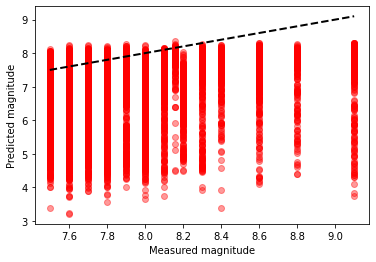

In [205]:
## ----- Quick plot of the predictions vs. true magnitudes ----- ###

fig4, ax = plt.subplots(facecolor = 'white')
ax.scatter(historic_test_mags_nonan, predict_hist, alpha = 0.4, facecolors = 'r', edgecolors = 'r')
ax.plot([historic_test_mags_nonan.min(), historic_test_mags_nonan.max()], [historic_test_mags_nonan.min(), historic_test_mags_nonan.max()], 'k--', alpha=1, lw=2)
ax.set_xlabel('Measured magnitude')
ax.set_ylabel('Predicted magnitude')
plt.show()
#     fig4.savefig(save_dir + '/scatter_' + m_name + '.png')
plt.close();

In [48]:
# Test data

### ----- Rename things ----- ###

measured_mags = test_mags
predicted_mags = predict.flatten()

### ----- Calculate the error and standard deviation ----- ###

errors = []

for idx in range(len(predicted_mags)):
    predicted = predicted_mags[idx]
    measured = measured_mags[idx]
    error = predicted - measured
    errors.append(error)

mean_error = np.mean(np.array(errors))
std_error = np.std(np.array(errors))

print('Mean error: ' + str(round(mean_error,3)))
print('Error standard deviation: ' + str(round(std_error,2)))

mean_errors.append(mean_error)
std_errors.append(std_error)

Mean error: 0.116
Error standard deviation: 0.51


[2.6 2.6 2.6 ... 3.1 3.1 3.1]
[2.9522285 2.5054133 2.4480536 ... 3.1308975 2.7546556 2.719372 ]


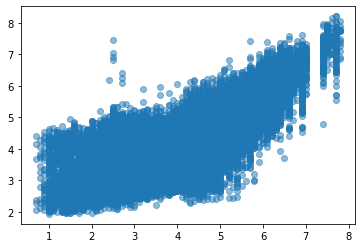

In [51]:
print(measured_mags)
print(predicted_mags)
plt.scatter(measured_mags, predicted_mags, alpha = 0.5)

In [80]:
### ----- Make the box and whisker plots with STF magnitude line ----- ###

Tt = shift_len / 2
M0_dyncm = Tt**3 * (0.625 * 10**23)
Mw = ((2/3) * np.log10(M0_dyncm)) - 10.73 # M0 in dyne-cm

print('Rupture duration: ' + str(Tt) + ' seconds')
print('M0: ' + str(M0_dyncm) + ' dyne-cm')
print('Mw: ' + str(round(Mw,2)))

bins = np.arange(7,79,1)/10
data_bins = []
print(bins)

Rupture duration: 57.0 seconds
M0: 1.15745625e+28 dyne-cm
Mw: 7.98
[0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4
 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2
 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.
 6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8]


In [81]:
c = 0
for abin in bins:
    print(abin)
    i = np.where(measured_mags == abin)[0]
    print(measured_mags[i])
    predict_bin = np.array(predicted_mags[i])
    print(predict_bin)
    data_bins.append(predict_bin)
    c+=1
    print(c)
    print('-----------------')

0.7
[0.7 0.7 0.7 0.7 0.7 0.7]
[3.6815984 4.153874  2.3789458 2.2734783 4.4002423 2.0448124]
1
-----------------
0.8
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
[3.702295  3.0598283 4.0436707 3.823896  2.2674356 2.114129  3.7842014
 2.7928212 3.2546775 2.409176  3.4599462 4.27761  ]
2
-----------------
0.9
[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
[2.393895  2.6747198 3.3303847 2.5823805 2.3916826 2.3631365 4.225246
 3.9883912 3.3556607 2.837836  2.1799252 2.7213628 3.6368976 2.2827988
 2.5478628 3.2080374 3.726047  2.0589094 2.7863374 4.3328285 4.4026866
 2.9725165 2.8756359 2.318752  2.713158  3.8840613 4.2022877 4.5423474
 3.8538516]
3
-----------------
1.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

[6.0575976 6.023661  6.3157177 5.4786363 6.460021  6.001673  5.9806314
 6.0112586 5.862909  5.715677  6.808459  6.3266797 5.9434733 6.1705403
 6.5225844 6.5467296 6.5303607 6.296388  5.5660253 6.2663445 6.4395356
 6.1468124 6.2916317 6.315326  6.135204  6.2046094 6.3285403 6.0433583
 6.1043515 5.163093  5.3298497 5.9418435 5.698368  6.0362535 5.9124804
 5.6529794 5.516874  5.566786  6.261449  5.321035  5.2727256 6.2952266
 6.614355  6.3186226 6.4626527 6.075212  5.9956555 6.3212895 5.938567
 6.124372  6.3658447 6.356169  6.1808405 5.730259  6.0774956 6.2049994
 5.898529  6.192742  6.418354  6.310407  6.558985  5.9692025 6.2692733
 6.628609  6.6145096 6.504482  6.9113345 6.094993  6.617226  6.284017
 6.193853  6.332154  6.0982246 6.0904765 6.4283433 6.20777   5.908833
 6.277593  6.6404605 6.19455   6.4769974 5.881801  6.2492795 5.726784
 6.1150007 6.1033425 5.9181924 6.27815   6.1571097 6.289121  6.3330464
 6.3522067 6.1608424 6.109226  6.1248255 5.8439794 6.153429  6.185259
 6.4032254 

In [82]:
print(len(data_bins))
print(len(bins))
print(np.array(data_bins).shape)
print(data_bins)

72
72
(72,)
[array([3.6815984, 4.153874 , 2.3789458, 2.2734783, 4.4002423, 2.0448124],
      dtype=float32), array([3.702295 , 3.0598283, 4.0436707, 3.823896 , 2.2674356, 2.114129 ,
       3.7842014, 2.7928212, 3.2546775, 2.409176 , 3.4599462, 4.27761  ],
      dtype=float32), array([2.393895 , 2.6747198, 3.3303847, 2.5823805, 2.3916826, 2.3631365,
       4.225246 , 3.9883912, 3.3556607, 2.837836 , 2.1799252, 2.7213628,
       3.6368976, 2.2827988, 2.5478628, 3.2080374, 3.726047 , 2.0589094,
       2.7863374, 4.3328285, 4.4026866, 2.9725165, 2.8756359, 2.318752 ,
       2.713158 , 3.8840613, 4.2022877, 4.5423474, 3.8538516],
      dtype=float32), array([4.1595526, 4.308313 , 2.3661292, 2.1191704, 2.8200185, 4.289608 ,
       2.0035238, 2.4139218, 2.8574955, 2.9403732, 3.3116038, 3.618819 ,
       4.006574 , 2.1328132, 3.236786 , 3.8256142, 4.2205677, 3.8295379,
       2.6196713, 3.9525015, 4.0921082, 4.3953204, 3.6443465, 3.2205114,
       4.1737437, 4.5704165, 2.734408 , 2.3585896, 2.

<ipython-input-82-4749b56f1cce>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(data_bins).shape)


In [83]:
print(bins.tolist())

[0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8]


Historic mean error: -0.904
Historic error standard deviation: 0.93
[7.6 7.6 7.6 ... 8.3 8.3 8.3]
[6.9201317 7.4782457 7.6316247 ... 5.09417   5.583189  5.774909 ]
9.1
7.5


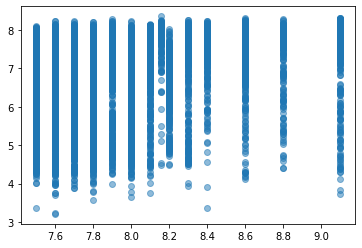

In [207]:
# Historic data

### ----- Rename things ----- ###

measured_mags_hist = historic_test_mags_nonan
predicted_mags_hist = predict_hist.flatten()

### ----- Calculate the error and standard deviation ----- ###

errors_hist = []

for idx in range(len(predicted_mags_hist)):
    predicted_hist = predicted_mags_hist[idx]
#     print(predicted_hist)
    measured_hist = measured_mags_hist[idx]
#     print(measured_hist)
    error_hist = predicted_hist - measured_hist
    errors_hist.append(error_hist)
#     print('-------------')

mean_error_hist = np.mean(np.array(errors_hist))
std_error_hist = np.std(np.array(errors_hist))

print('Historic mean error: ' + str(round(mean_error_hist,3)))
print('Historic error standard deviation: ' + str(round(std_error_hist,2)))

print(measured_mags_hist)
print(predicted_mags_hist)
plt.scatter(measured_mags_hist, predicted_mags_hist, alpha = 0.5);

print(historic_test_mags_nonan.max())
print(historic_test_mags_nonan.min())

In [210]:
### ----- Make the box and whisker plots with STF magnitude line ----- ###

bins_hist = np.arange(75,92,1)/10
data_bins_hist = []
print(bins_hist)

c = 0
for abin in bins_hist:
    print(abin)
    i = np.where(measured_mags_hist == abin)[0]
    print(measured_mags_hist[i])
    predict_bin_hist = np.array(predicted_mags_hist[i])
    print(predict_bin_hist)
    data_bins_hist.append(predict_bin_hist)
    c+=1
    print(c)
    print('-----------------')

print(len(data_bins_hist))
print(len(bins_hist))
print(np.array(data_bins_hist).shape)
#print(data_bins_hist)

print(bins_hist.tolist())

[7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9 9.  9.1]
7.5
[7.5 7.5 7.5 ... 7.5 7.5 7.5]
[7.218424  7.237654  7.348271  ... 6.7464976 4.609841  5.05516  ]
1
-----------------
7.6
[7.6 7.6 7.6 ... 7.6 7.6 7.6]
[6.9201317 7.4782457 7.6316247 ... 6.8532763 6.6385913 6.075805 ]
2
-----------------
7.7
[7.7 7.7 7.7 ... 7.7 7.7 7.7]
[7.8952413 7.2935367 7.0846014 ... 7.6269574 7.1254954 7.345591 ]
3
-----------------
7.8
[7.8 7.8 7.8 ... 7.8 7.8 7.8]
[7.3969502 7.452343  7.7739863 ... 5.3758163 5.5731115 6.195056 ]
4
-----------------
7.9
[7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9
 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9
 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9
 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9
 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9
 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9 7.9
 7.9 7.9

<ipython-input-210-9722bf8788a8>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(data_bins_hist).shape)


In [212]:
data_bins_all = data_bins + data_bins_hist

In [213]:
print(data_bins_all)

[array([3.6815984, 4.153874 , 2.3789458, 2.2734783, 4.4002423, 2.0448124],
      dtype=float32), array([3.702295 , 3.0598283, 4.0436707, 3.823896 , 2.2674356, 2.114129 ,
       3.7842014, 2.7928212, 3.2546775, 2.409176 , 3.4599462, 4.27761  ],
      dtype=float32), array([2.393895 , 2.6747198, 3.3303847, 2.5823805, 2.3916826, 2.3631365,
       4.225246 , 3.9883912, 3.3556607, 2.837836 , 2.1799252, 2.7213628,
       3.6368976, 2.2827988, 2.5478628, 3.2080374, 3.726047 , 2.0589094,
       2.7863374, 4.3328285, 4.4026866, 2.9725165, 2.8756359, 2.318752 ,
       2.713158 , 3.8840613, 4.2022877, 4.5423474, 3.8538516],
      dtype=float32), array([4.1595526, 4.308313 , 2.3661292, 2.1191704, 2.8200185, 4.289608 ,
       2.0035238, 2.4139218, 2.8574955, 2.9403732, 3.3116038, 3.618819 ,
       4.006574 , 2.1328132, 3.236786 , 3.8256142, 4.2205677, 3.8295379,
       2.6196713, 3.9525015, 4.0921082, 4.3953204, 3.6443465, 3.2205114,
       4.1737437, 4.5704165, 2.734408 , 2.3585896, 2.9753978, 3.6

ValueError: The number of FixedLocator locations (89), usually from a call to set_ticks, does not match the number of ticklabels (85).

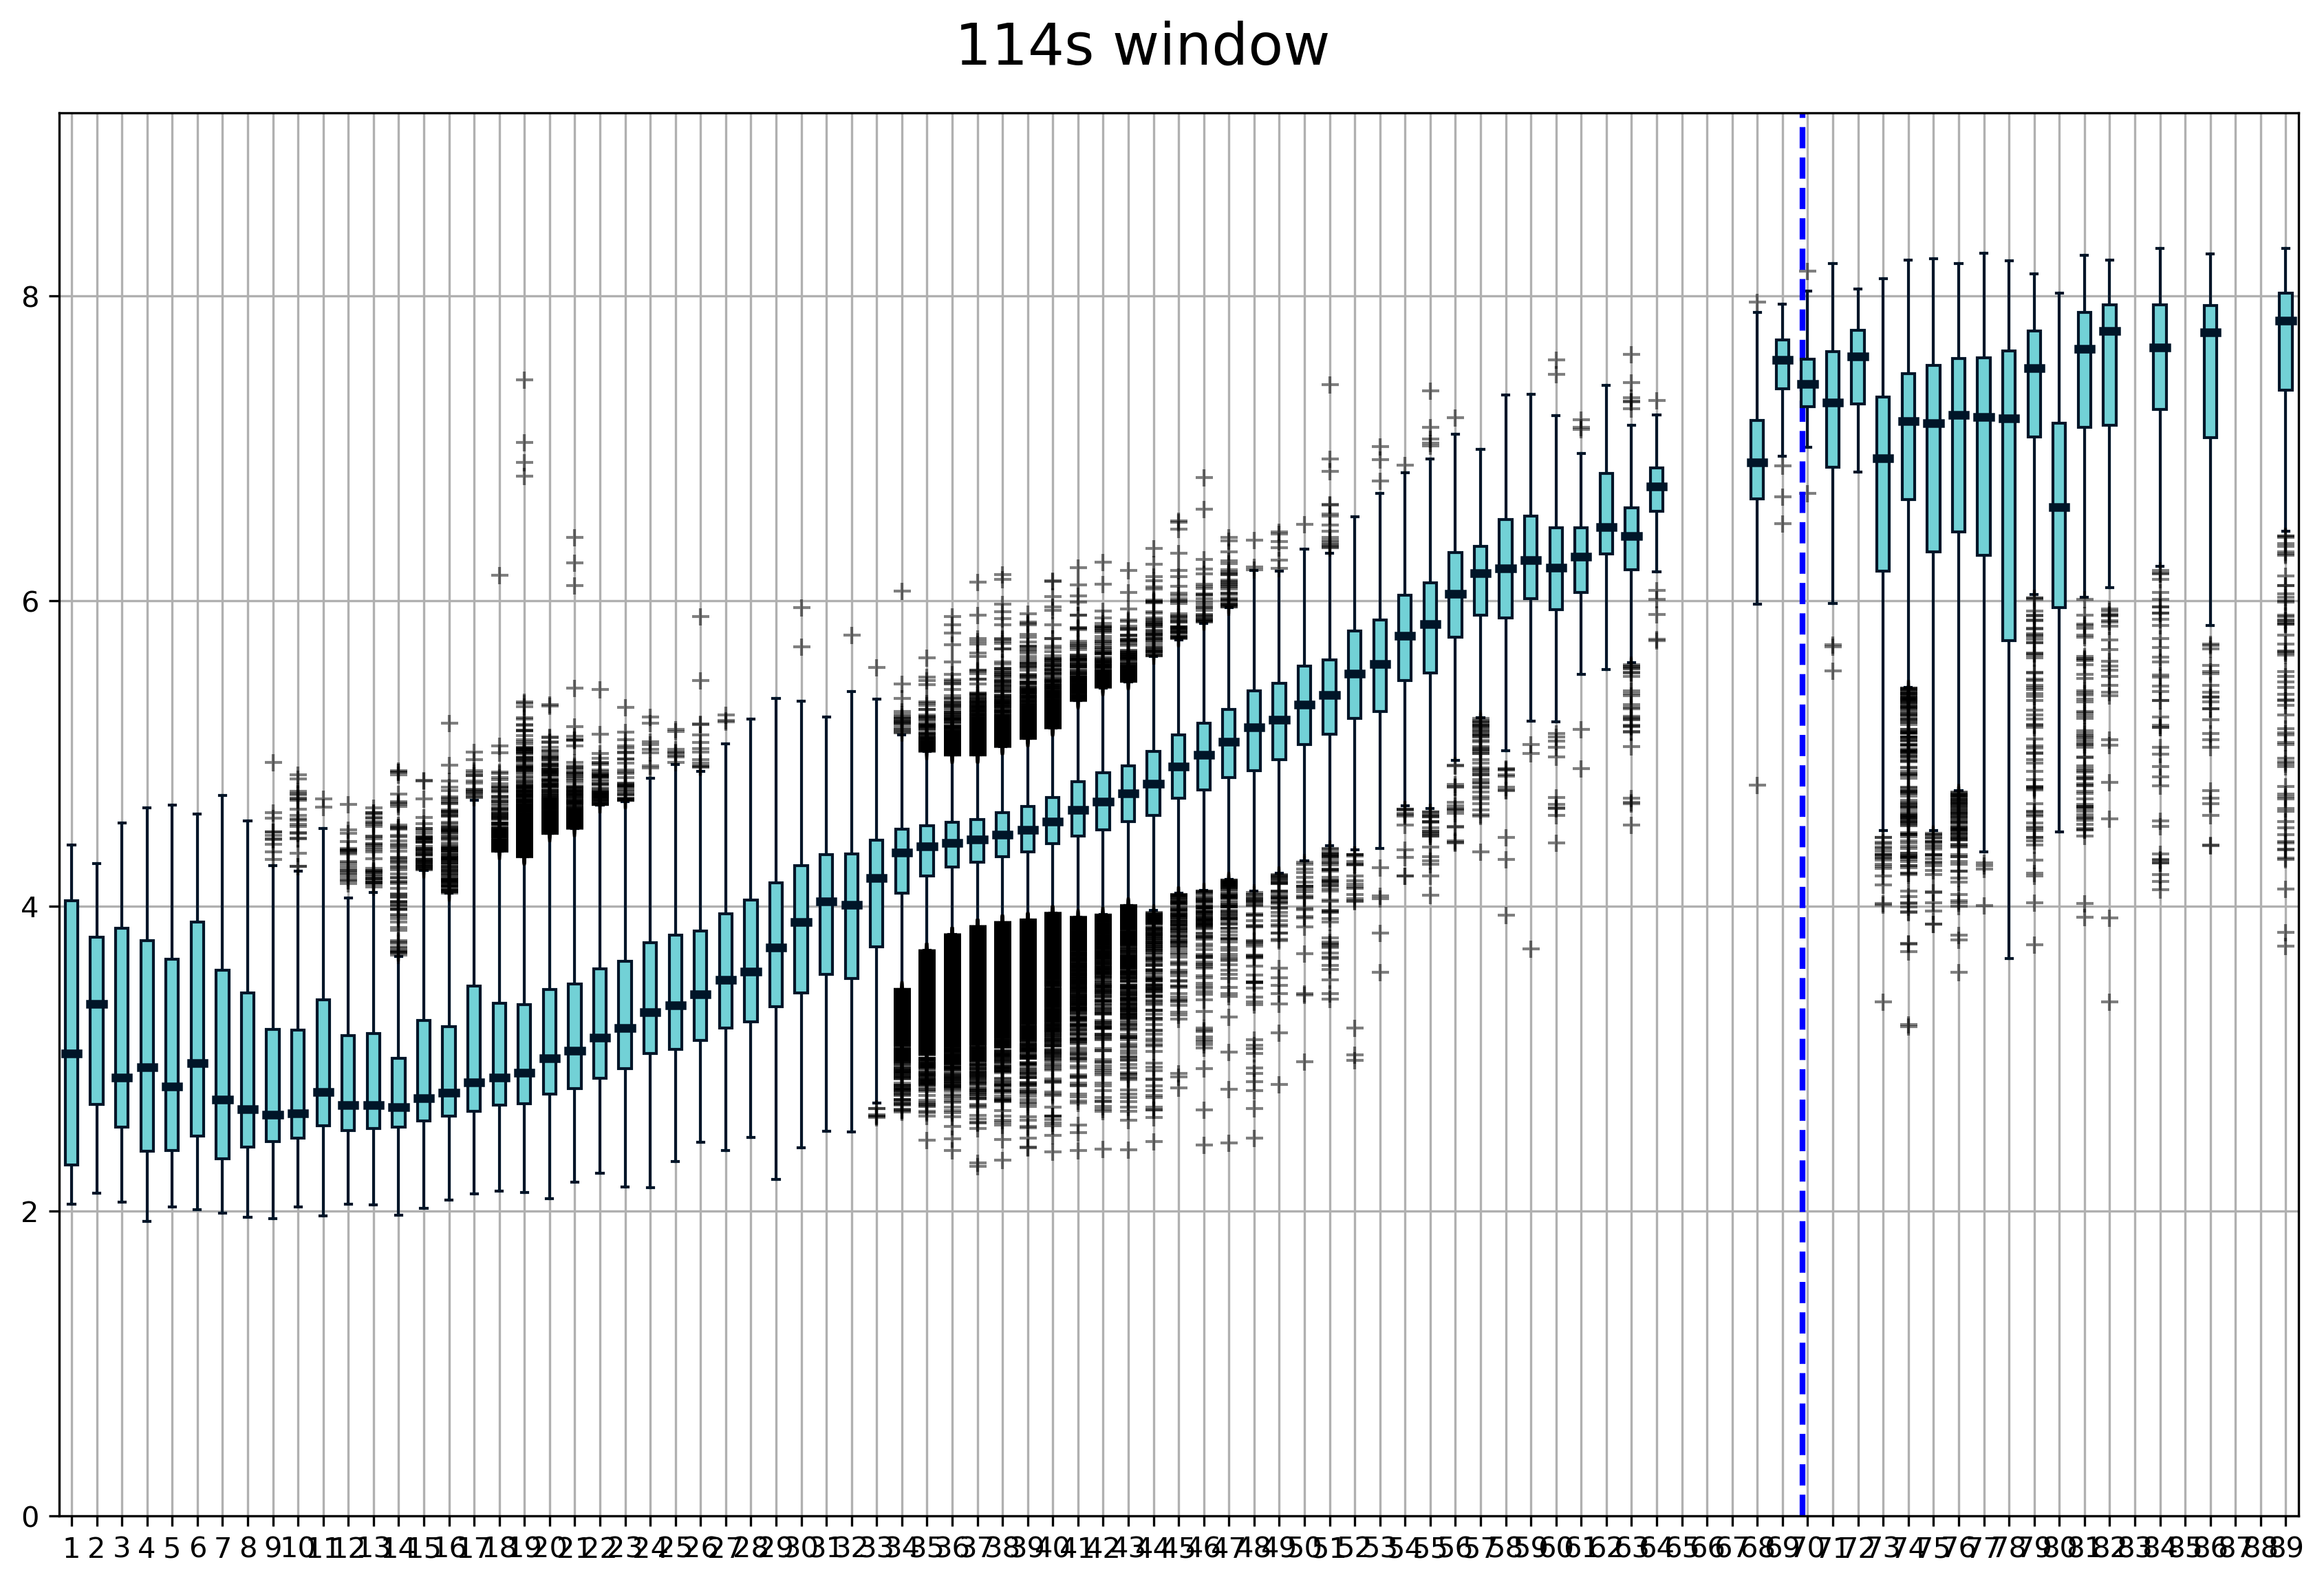

In [216]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize =(14, 9), dpi = 300, facecolor = 'white')

fig.suptitle(str(shift_len) + 's window', fontsize = 20, y = 0.93, color = 'black')
ax = fig.add_subplot(111)
ax.set_facecolor('white')
# ax.text(x = 30, y = 8.8, s = 'Model: ' + m_name, fontsize = 13, color = 'black')
ax.grid(which = 'major', axis = 'y', markevery = 0.5)
ax.grid(which = 'major', axis = 'x')
ax.set_ylim(0,9.2)

bp = ax.boxplot(data_bins_all, notch = False, patch_artist = True)
ax.axvline((Mw-1)*10, color = 'blue', linestyle = '--', linewidth = 2) # Position = (magnitude - 1)*10

for patch in bp['boxes']:
    patch.set_facecolor('#72d1d6')
    patch.set_edgecolor('#001528')
for median in bp['medians']:
    median.set(color = '#001528', linewidth = 3)
for whisker in bp['whiskers']:
    whisker.set(color = '#001528', linewidth = 1)
for cap in bp['caps']:
    cap.set(color = '#001528', linewidth = 1)
for flier in bp['fliers']:
    flier.set(marker = '+', color = '#001528', alpha = 0.5)

bins_all = np.arange(7,92,1)/10
bins_list_all = bins_all.tolist()
ax.set_xticklabels(bins_list_all, fontsize = 14, color = 'black')
ax.xaxis.set_major_locator(ticker.FixedLocator([4, 14, 24, 34, 44, 54, 64, 74, 84, 94]))
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.tick_params(labelsize = 14, color = 'black')
ax.set_ylabel('Predicted magnitude', fontsize = 16, color = 'black')
ax.set_xlabel('Measured magnitude', fontsize = 16, color = 'black')

linex = [4, 14, 24, 34, 44, 54, 64, 74]
liney = [1, 2, 3, 4, 5, 6, 7, 8]

ax.plot(linex, liney, '#f01f42', linestyle = '--', linewidth = 3, alpha = 0.5)
ax.text(s = 'Testing data', x = 2, y = 8.5, fontsize = 18, backgroundcolor = '#72d1d6', color = 'black')
ax.text(s = 'STF magnitude: ' + str(round(Mw,2)), x = 2, y = 7.9, fontsize = 18, backgroundcolor = 'blue', color = 'white')

plt.show()
# #     plt.savefig(save_dir + '/boxplot_durline_' + m_name + '.png', format = 'PNG', facecolor = 'white', transparent = False)
# plt.close();

In [124]:
# Combining just for the plot doesn't work - need to do predictions on the combination

7.8

In [218]:
all_test_waves = np.concatenate((shift_test_waves_t, shift_historic_test_waves_nonan))
print(all_test_waves.shape)
all_test_mags = np.concatenate((test_mags, historic_test_mags_nonan))
print(all_test_mags.shape)

(337516, 2280, 3)
(337516,)


In [249]:
all_test_mags = np.round_(all_test_mags, decimals = 1)

In [250]:
### ----- What trained model are we loading? ----- ###

latest_model = '/home/sdybing/mlaapde/training/v1b_2920609samps_114s_window/v1b_2920609samps_114s_029.h5'
print(latest_model)
model.load_weights(latest_model)
print('Predicting...')
predict_all = model.predict(all_test_waves)

print(predict_all.shape)

/home/sdybing/mlaapde/training/v1b_2920609samps_114s_window/v1b_2920609samps_114s_029.h5
Predicting...
(337516, 1)


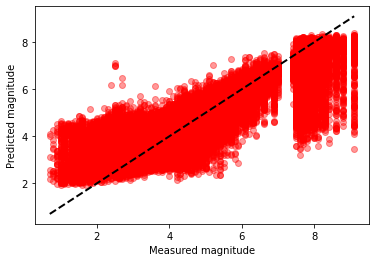

In [251]:
## ----- Quick plot of the predictions vs. true magnitudes ----- ###

fig4, ax = plt.subplots(facecolor = 'white')
ax.scatter(all_test_mags, predict_all, alpha = 0.4, facecolors = 'r', edgecolors = 'r')
ax.plot([all_test_mags.min(), all_test_mags.max()], [all_test_mags.min(), all_test_mags.max()], 'k--', alpha=1, lw=2)
ax.set_xlabel('Measured magnitude')
ax.set_ylabel('Predicted magnitude')
plt.show()
#     fig4.savefig(save_dir + '/scatter_' + m_name + '.png')
plt.close();

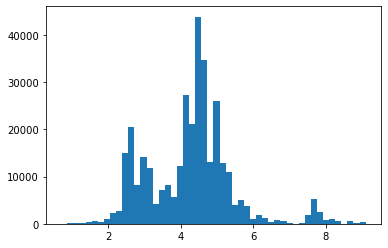

In [252]:
plt.hist(measured_mags, bins = 50);

In [253]:
print(np.round_(measured_mags, decimals = 1))

[2.6 2.6 2.6 ... 8.3 8.3 8.3]


In [254]:
# measured_mags = np.round_(measured_mags, decimals = 1)

In [261]:
### ----- Rename things ----- ###

measured_mags = all_test_mags
predicted_mags = predict_all.flatten()

### ----- Calculate the error and standard deviation ----- ###

errors = []

for idx in range(len(predicted_mags)):
    predicted = predicted_mags[idx]
    measured = measured_mags[idx]
    error = predicted - measured
    errors.append(error)

mean_error = np.mean(np.array(errors))
std_error = np.std(np.array(errors))

print('Mean error: ' + str(round(mean_error,3)))
print('Error standard deviation: ' + str(round(std_error,2)))

# mean_errors.append(mean_error)
# std_errors.append(std_error)

### ----- Make the box and whisker plots with STF magnitude line ----- ###

Tt = shift_len / 2
M0_dyncm = Tt**3 * (0.625 * 10**23)
Mw = ((2/3) * np.log10(M0_dyncm)) - 10.73 # M0 in dyne-cm

print('Rupture duration: ' + str(Tt) + ' seconds')
print('M0: ' + str(M0_dyncm) + ' dyne-cm')
print('Mw: ' + str(round(Mw,2)))

bins = np.arange(7,92,1)/10
data_bins = []

for abin in bins:
#     print(abin)
    i = np.where(measured_mags == abin)[0]
#     print(measured_mags[i])
    predict_bin = np.array(predicted_mags[i])
#     print(predict_bin)
    data_bins.append(predict_bin)
#     print('-----')

Mean error: 0.076
Error standard deviation: 0.57
Rupture duration: 57.0 seconds
M0: 1.15745625e+28 dyne-cm
Mw: 7.98


In [256]:
print(bins)

[0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4
 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2
 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.
 6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8
 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9 9.  9.1]


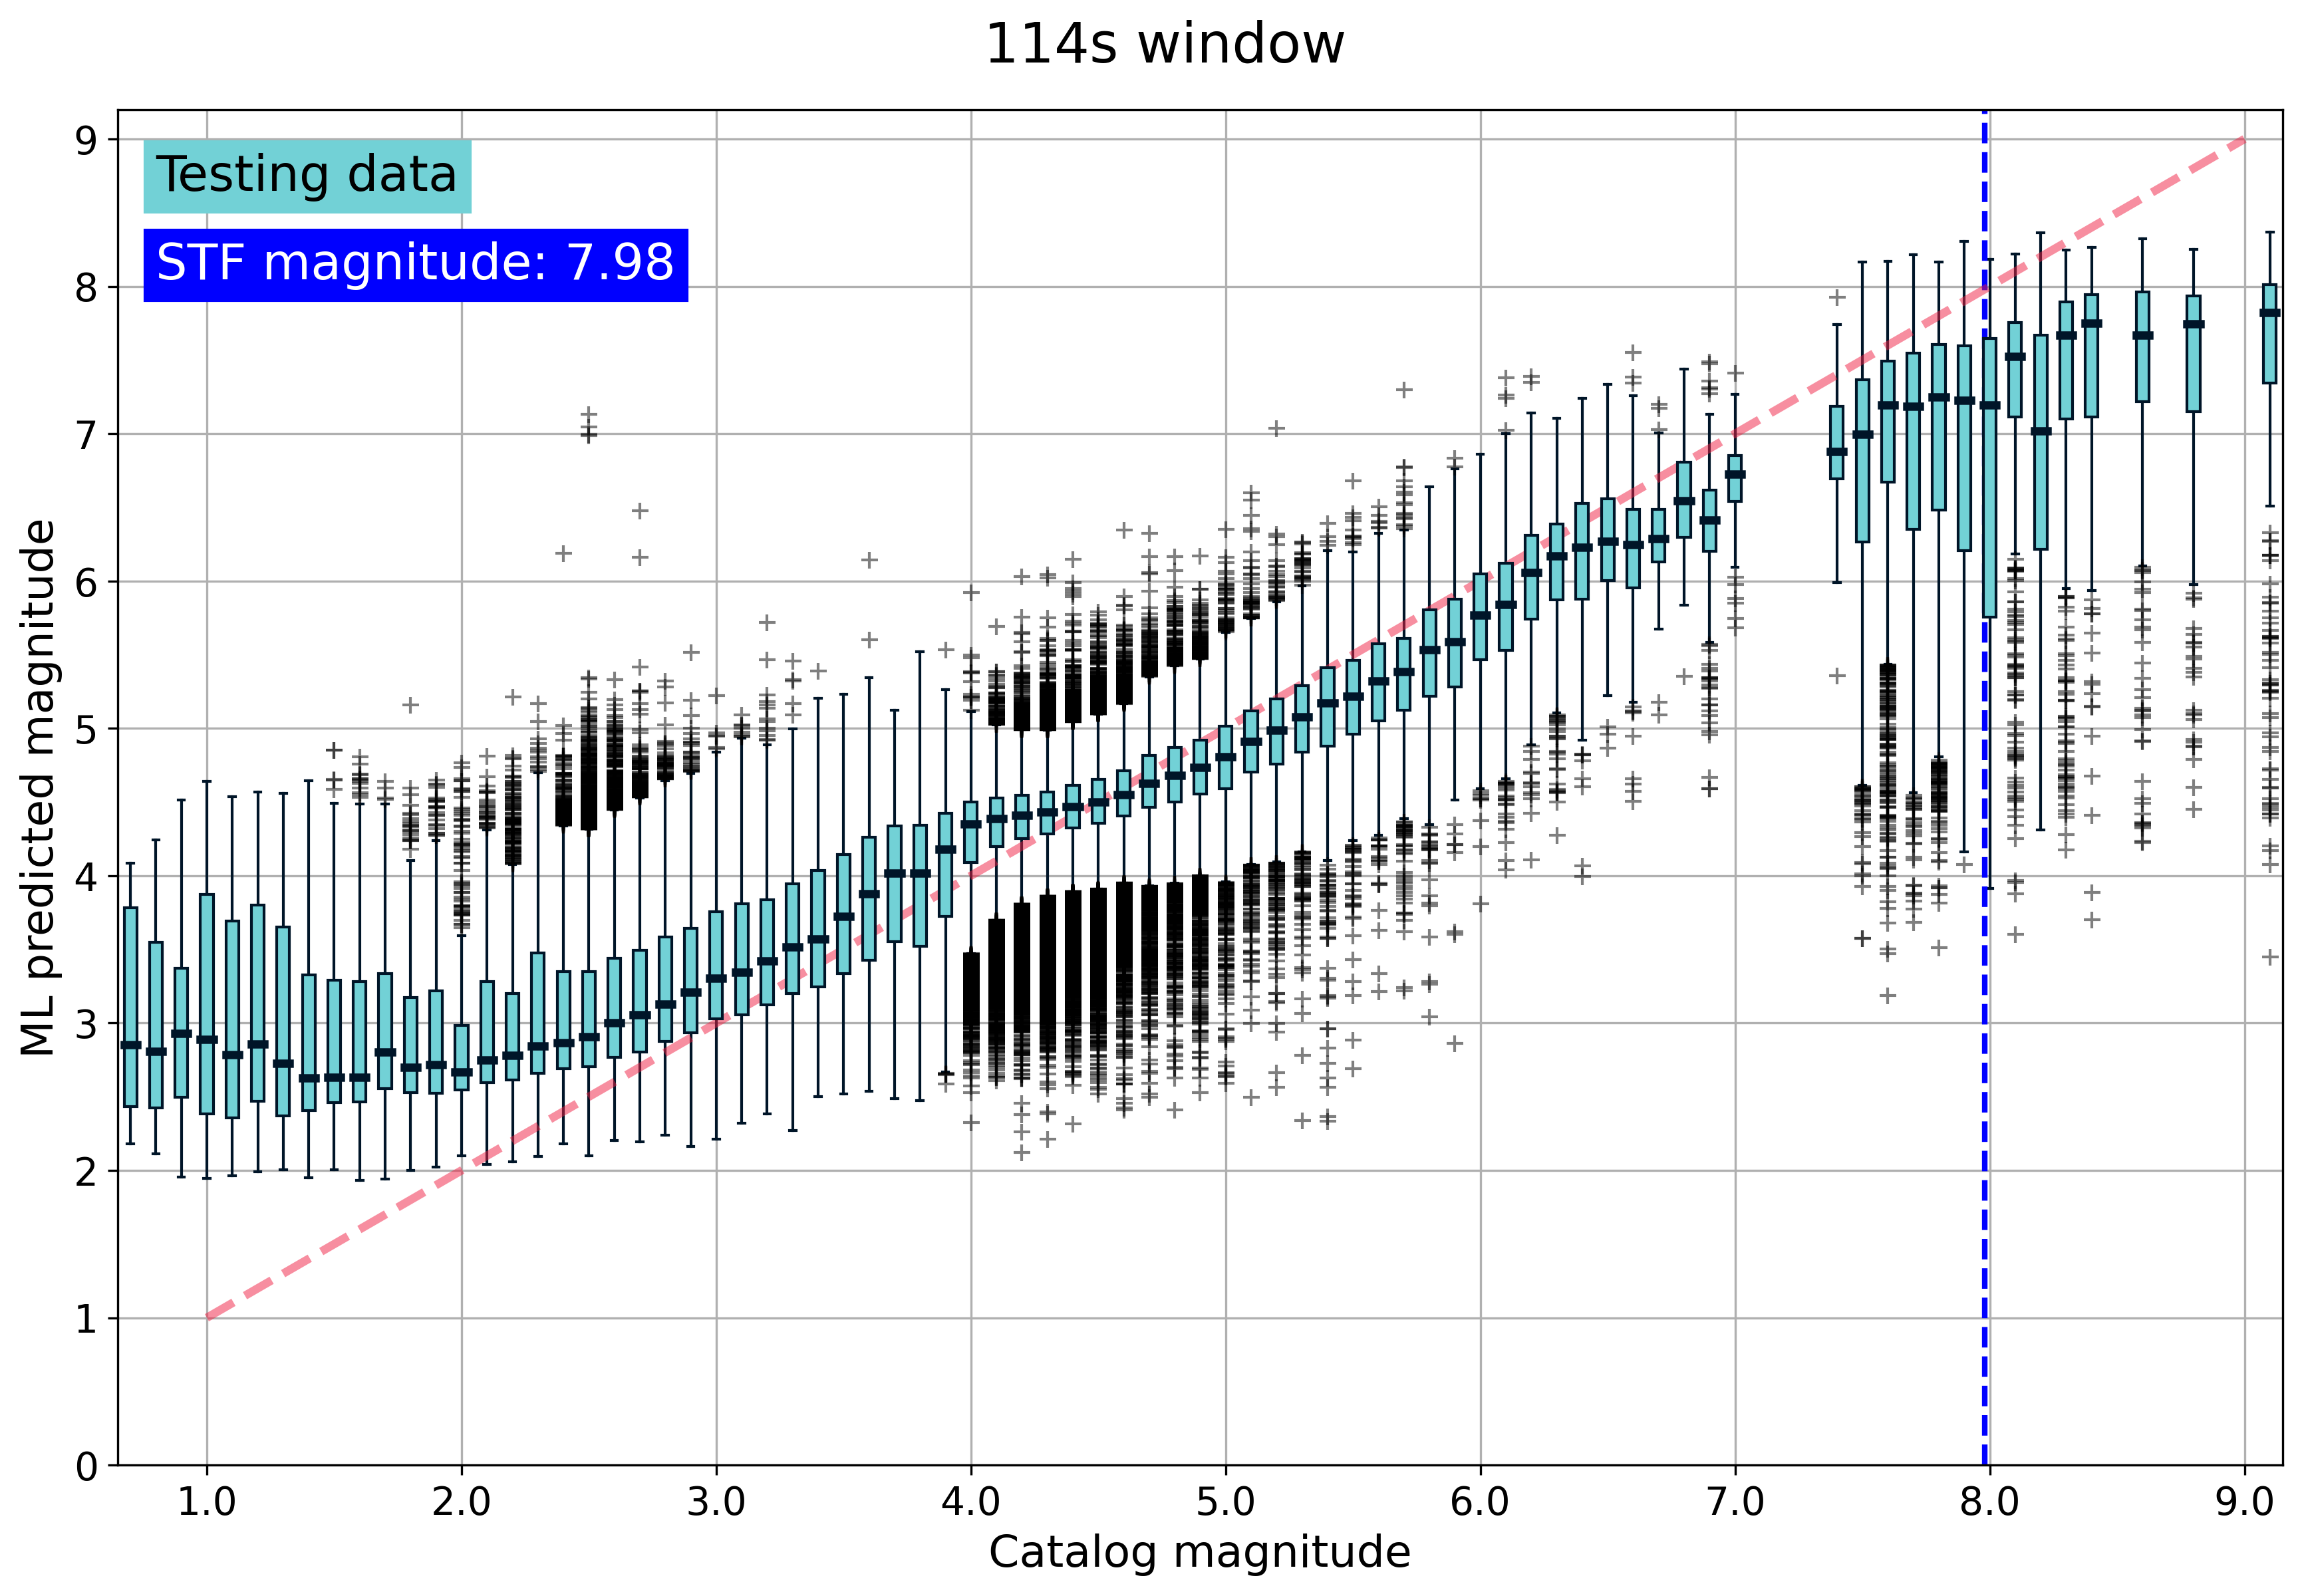

In [265]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize = (14, 9), dpi = 300, facecolor = 'white')

fig.suptitle(str(shift_len) + 's window', fontsize = 20, y = 0.93, color = 'black')
ax = fig.add_subplot(111)
ax.set_facecolor('white')
# ax.text(x = 30, y = 8.8, s = 'Model: ' + m_name, fontsize = 13, color = 'black')
ax.grid(which = 'major', axis = 'y', markevery = 0.5)
ax.grid(which = 'major', axis = 'x')
ax.set_ylim(0,9.2)

bp = ax.boxplot(data_bins, notch = False, patch_artist = True)
ax.axvline(((Mw*10)-6), color = 'blue', linestyle = '--', linewidth = 2)

for patch in bp['boxes']:
    patch.set_facecolor('#72d1d6')
    patch.set_edgecolor('#001528')
for median in bp['medians']:
    median.set(color = '#001528', linewidth = 3)
for whisker in bp['whiskers']:
    whisker.set(color = '#001528', linewidth = 1)
for cap in bp['caps']:
    cap.set(color = '#001528', linewidth = 1)
for flier in bp['fliers']:
    flier.set(marker = '+', color = '#001528', alpha = 0.5)

bins_list = bins.tolist()
ax.set_xticklabels(bins_list, fontsize = 14, color = 'black')
ax.xaxis.set_major_locator(ticker.FixedLocator([4, 14, 24, 34, 44, 54, 64, 74, 84]))
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.tick_params(labelsize = 14, color = 'black')
ax.set_ylabel('ML predicted magnitude', fontsize = 16, color = 'black')
ax.set_xlabel('Catalog magnitude', fontsize = 16, color = 'black')

linex = [4, 14, 24, 34, 44, 54, 64, 74, 84]
liney = [1, 2, 3, 4, 5, 6, 7, 8, 9]

ax.plot(linex, liney, '#f01f42', linestyle = '--', linewidth = 3, alpha = 0.5)
ax.text(s = 'Testing data', x = 2, y = 8.65, fontsize = 18, backgroundcolor = '#72d1d6', color = 'black')
ax.text(s = 'STF magnitude: ' + str(round(Mw,2)), x = 2, y = 8.05, fontsize = 18, backgroundcolor = 'blue', color = 'white')

plt.show()
# #     plt.savefig(save_dir + '/boxplot_durline_' + m_name + '.png', format = 'PNG', facecolor = 'white', transparent = False)
# plt.close();

In [ ]:
# Blue line not in right spot